In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

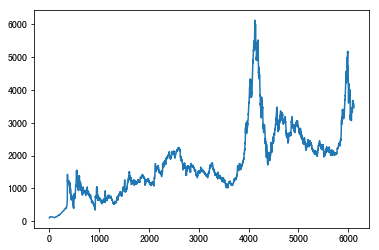

In [2]:
#——————————————————导入数据——————————————————————
f=open('stock_dataset.csv')  
df=pd.read_csv(f)     #读入股票数据
data=np.array(df['top'])   #获取最高价序列
data=data[::-1]      #反转，使数据按照日期先后顺序排列
#以折线图展示data
plt.figure()
plt.plot(data)
plt.show()
normalize_data=(data-np.mean(data))/np.std(data)  #标准化
normalize_data=normalize_data[:,np.newaxis]       #增加维度

In [9]:
#生成训练集
#设置常量
time_step=20      #时间步
rnn_unit=10       #hidden layer units
batch_size=60     #每一批次训练多少个样例
input_size=1      #输入层维度
output_size=1     #输出层维度
lr=0.0006         #学习率
train_x,train_y=[],[]   #训练集
for i in range(len(normalize_data)-time_step-1):
    x=normalize_data[i:i+time_step]
    y=normalize_data[i+1:i+time_step+1]
    train_x.append(x.tolist())
    train_y.append(y.tolist()) 


<class 'list'>


In [41]:
#——————————————————定义神经网络变量——————————————————
%matplotlib qt
tf.reset_default_graph()
X=tf.placeholder(tf.float32, [None,time_step,input_size])    #每批次输入网络的tensor
Y=tf.placeholder(tf.float32, [None,time_step,output_size])   #每批次tensor对应的标签
#输入层、输出层权重、偏置
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
        }
def lstm(batch): 
    

     #参数：输入网络批次数目
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [53]:
#——————————————————定义神经网络变量——————————————————
%matplotlib qt
tf.reset_default_graph()
X=tf.placeholder(tf.float32, [None,time_step,input_size])    #每批次输入网络的tensor
Y=tf.placeholder(tf.float32, [None,time_step,output_size])   #每批次tensor对应的标签
#输入层、输出层权重、偏置
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
        }
def lstm(batch): 
    

     #参数：输入网络批次数目
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states
#——————————————————训练模型——————————————————

def train_lstm():
    global batch_size
    save_dir = './stock_save/ckpt/stock'
    fig = plt.figure(figsize=(20, 3))  # dpi参数指定绘图对象的分辨率，即每英寸多少个像素，缺省值为80
    axes = fig.add_subplot(1, 1, 1)
    line3, = axes.plot(normalize_data, 'r', label='实际')
    plt.ion()
    plt.show()
    pred,_=lstm(batch_size)
    #损失函数
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #重复训练10000次
        for i in range(1):
            step=0
            start=0
            end=start+batch_size
            predict=[]
            #每个内循环是100次，数据是0-60，60-120，120-180，递增
            while(end<len(train_x)):
                
#                 print('start,end,step',start,end,step)
                _,loss_,p=sess.run([train_op,loss,pred],feed_dict={X:train_x[start:end],Y:train_y[start:end]})
                predict.append(p[-1])
                start+=batch_size
                end=start+batch_size
                #每10步保存一次参数
                if step%10==0:
#                     print(i,step,loss_)
                    saver.save(sess,save_dir,)
#                     print("保存模型：",saver.save(sess,save_dir,))
                step+=1
                print(np.array(train_x[start:end]).shape,p.shape,p[-1].shape)
#             print(i,loss_)
            line1, = axes.plot(predict, 'b--', label='rnn计算结果 '+str(i))
#             plt.plot(list(range(len(normalize_data), len(normalize_data) + len(predict))), predict, color='r')
            axes.grid()
            fig.tight_layout()
            plt.legend(handles=[line1,line3])
            plt.title('递归神经网络')
            plt.pause(0.05)
        plt.ioff()
        plt.show()

train_lstm()


(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(

(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(60, 20, 1) (1200, 1) (1,)
(

In [59]:
#——————————————————定义神经网络变量——————————————————
tf.reset_default_graph()
X=tf.placeholder(tf.float32, [None,time_step,input_size])    #每批次输入网络的tensor
Y=tf.placeholder(tf.float32, [None,time_step,output_size])   #每批次tensor对应的标签
#输入层、输出层权重、偏置
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
        }
def lstm(batch): 
    

     #参数：输入网络批次数目
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

#————————————————预测模型————————————————————
# tf.reset_default_graph()
def prediction():

    save_dir = './stock_save/ckpt/stock'
    pred,_=lstm(1)      #预测时只输入[1,time_step,input_size]的测试数据
    saver=tf.train.Saver()
    with tf.Session() as sess:
        #参数恢复
#         module_file = tf.train.latest_checkpoint('./stock_save/ckpt/')
        saver.restore(sess, save_dir) 

        #取训练集最后一行为测试样本。shape=[1,time_step,input_size]
#         prev_seq=train_x[-1]
        prev_seq=train_x[1]
        array=np.array(train_x)
        print('train_x',array.shape)
        array=np.array(prev_seq)
        print('prev_seq',array.shape)
        predict=[]
        #得到之后100个预测结果
        for i in range(5000):
            next_seq=sess.run(pred,feed_dict={X:[prev_seq]})
#             print('prev_seq',len(prev_seq))
#             print('next_seq',next_seq.shape)
            predict.append(next_seq[-1])
            #每次得到最后一个时间步的预测结果，与之前的数据加在一起，形成新的测试样本
            prev_seq=np.vstack((prev_seq[1:],next_seq[-1]))
        #以折线图表示结果
        plt.figure()
        plt.plot(list(range(len(normalize_data))), normalize_data, color='b')
        plt.plot(list(range(len(normalize_data), len(normalize_data) + len(predict))), predict, color='r')
        plt.show()

prediction() 

INFO:tensorflow:Restoring parameters from ./stock_save/ckpt/stock
train_x (6090, 20, 1)
prev_seq (20, 1)


In [92]:
train_x_np = np.array(train_x)
train_y_np = np.array(train_y)

In [95]:
print(train_x_np.shape)
print(train_y_np.shape)
print(normalize_data.shape)
print(len(train_x))

(6090, 20, 1)
(6090, 20, 1)
(6111, 1)
6090
